# Tugas Besar Deep Learning - Klasifikasi Wajah Mahasiswa

Kelompok PresenFace:
- Joshua Palti Sinaga (122140141)
- Alfajar (122140122)
- Rustian Afencius Marbun (122140155)

## 1. Setup Environment & Configuration

In [ ]:
# Install library yang dibutuhkan
!pip install insightface onnxruntime-gpu scikit-image facenet_pytorch gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 21.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 136.3 MB/s eta 

In [ ]:
import os
import json
import random
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report, confusion_matrix
from facenet_pytorch import InceptionResnetV1
from tqdm.auto import tqdm
from insightface.app import FaceAnalysis
from skimage import transform as trans
from torch.cuda.amp import autocast, GradScaler

In [ ]:
# Konfigurasi Global
CONFIG = {
    "raw_dir": "Train",
    "processed_dir": "Dataset_Aligned_224",
    "img_size": 224,
    "crop_scale": 0.8,
    "skip_face_preprocess": False, # Set True jika data sudah bersih/crop

    # Training Params
    "batch_size": 16,
    "epochs": 40,
    "lr": 1e-4,
    "weight_decay": 5e-4,

    # Hardware & Misc
    "use_amp": True,  # Automatic Mixed Precision
    "seed": 42,
    "artifacts_dir": "artifacts",
}

In [ ]:
# Setup Device
CONFIG["device"] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Path(CONFIG["artifacts_dir"]).mkdir(parents=True, exist_ok=True)

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG["seed"])
print(f"Environment siap. Device: {CONFIG['device']}")

Environment siap. Device: cuda


## 2. Dataset Acquisition

In [ ]:
GDRIVE_ID = "1sp3bKOTLQc6qNp5hPddP7uNW4_HuxCJn"
RAW_DIR = Path(CONFIG["raw_dir"])

if not RAW_DIR.exists():
    print("Download dataset...")
    !gdown --id {GDRIVE_ID} -O dataset.zip
    print("Extracting...")
    with zipfile.ZipFile("dataset.zip", "r") as z:
        z.extractall(".")
    print("Dataset berhasil diekstrak.")
else:
    print(f"Folder dataset '{RAW_DIR}' sudah ada. Skip download.")

Download dataset...
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1sp3bKOTLQc6qNp5hPddP7uNW4_HuxCJn
From (redirected): https://drive.google.com/uc?id=1sp3bKOTLQc6qNp5hPddP7uNW4_HuxCJn&confirm=t&uuid=05666b3e-c1f7-49fd-9805-56293a234777
To: /content/dataset.zip
100% 409M/409M [00:05<00:00, 79.4MB/s]
Extracting...
Dataset berhasil diekstrak.


## 3. Data Preprocessing Preparation (InsightFace)

Mendefinisikan fungsi utilitas custom_norm_crop untuk melakukan alignment wajah berdasarkan landmark mata/hidung/mulut agar posisi wajah standar.

In [ ]:
def custom_norm_crop(img, landmark, image_size=112, crop_scale=1.0):
    """
    Melakukan alignment dan cropping wajah berdasarkan landmark.
    Menggunakan SimilarityTransform untuk rotasi dan scaling.
    """
    # Standar posisi landmark untuk arcface/insightface
    src = np.array([
        [38.2946, 51.6963],
        [73.5318, 51.5014],
        [56.0252, 71.7366],
        [41.5493, 92.3655],
        [70.7299, 92.2041] ], dtype=np.float32)

    if crop_scale != 1.0:
        src = (src - 56) * crop_scale + 56

    if image_size != 112:
        src = src * (image_size / 112.0)

    dst = landmark.astype(np.float32)
    tform = trans.SimilarityTransform()
    tform.estimate(dst, src)
    M = tform.params[0:2, :]

    warped = cv2.warpAffine(img, M, (image_size, image_size), borderValue=0.0)
    return warped


In [ ]:
def preprocess_faces_insightface(raw_dir: Path, processed_dir: Path):
    print(f"[INFO] Memproses dataset ke {processed_dir} ...")

    total, ok, skipped = 0, 0, 0
    fallback_files = []

    class_dirs = [p for p in raw_dir.iterdir() if p.is_dir()]

    for cls_dir in tqdm(sorted(class_dirs), desc="Processing Classes"):
        out_cls = processed_dir / cls_dir.name
        out_cls.mkdir(parents=True, exist_ok=True)

        imgs = [p for p in cls_dir.glob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".webp"]]

        for img_path in imgs:
            total += 1
            out_path = out_cls / (img_path.stem + ".jpg")

            if out_path.exists():
                ok += 1
                continue

            img = cv2.imread(str(img_path))
            if img is None:
                skipped += 1
                continue

            faces = face_app.get(img)
            if len(faces) == 0:
                skipped += 1
                fallback_files.append(str(img_path))
                continue

            # Ambil wajah dengan skor deteksi tertinggi
            target_face = sorted(faces, key=lambda x: x.det_score, reverse=True)[0]
            aligned_face = custom_norm_crop(img, target_face.kps, image_size=CONFIG["img_size"], crop_scale=CONFIG["crop_scale"])

            cv2.imwrite(str(out_path), aligned_face)
            ok += 1

    print(f"Selesai. Total: {total} | OK: {ok} | Skipped: {skipped}")

## 4. Eksekusi Preprocessing

In [ ]:
# Inisialisasi Model Deteksi Wajah
providers = ['CUDAExecutionProvider'] if torch.cuda.is_available() else ['CPUExecutionProvider']
face_app = FaceAnalysis(name='buffalo_l', providers=providers)
face_app.prepare(ctx_id=0, det_size=(640, 640))
print("InsightFace Detector Loaded.")

PROCESSED_DIR = Path(CONFIG["processed_dir"])

if not CONFIG["skip_face_preprocess"]:
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    preprocess_faces_insightface(Path(CONFIG["raw_dir"]), PROCESSED_DIR)
else:
    PROCESSED_DIR = Path(CONFIG["raw_dir"])
    print("Menggunakan raw directory (Skip Preprocessing).")

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:05<00:00, 50565.23KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

Processing Classes:   0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Selesai. Total: 275 | OK: 275 | Skipped: 0


## 5. Data Loaders & Transformasi

In [ ]:
train_tf = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.RandomErasing(p=0.2)
])

val_tf = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
# Load Dataset Structure
ds_base = datasets.ImageFolder(str(PROCESSED_DIR))
class_names = ds_base.classes
num_classes = len(class_names)

# Split Strategy: 1 sampel per kelas untuk validasi, sisanya train (sesuai kode asli)
# Anda bisa mengubah logic ini menjadi random_split jika data cukup banyak
train_idx, val_idx = [], []
targets = np.array(ds_base.targets)

for i in range(num_classes):
    indices = np.where(targets == i)[0]
    if len(indices) > 0:
        np.random.shuffle(indices)
        val_idx.append(indices[0])      # 1 sampel untuk validasi
        train_idx.extend(indices[1:])   # Sisanya untuk training

train_dataset = Subset(datasets.ImageFolder(str(PROCESSED_DIR), transform=train_tf), train_idx)
val_dataset   = Subset(datasets.ImageFolder(str(PROCESSED_DIR), transform=val_tf), val_idx)

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=2, pin_memory=True),
    "val":   DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2, pin_memory=True),
}

print(f"Classes: {num_classes}")
print(f"Train Samples: {len(train_dataset)}")
print(f"Val Samples: {len(val_dataset)}")

Classes: 70
Train Samples: 205
Val Samples: 70


## 6. Exploratory Data Analysis (EDA)

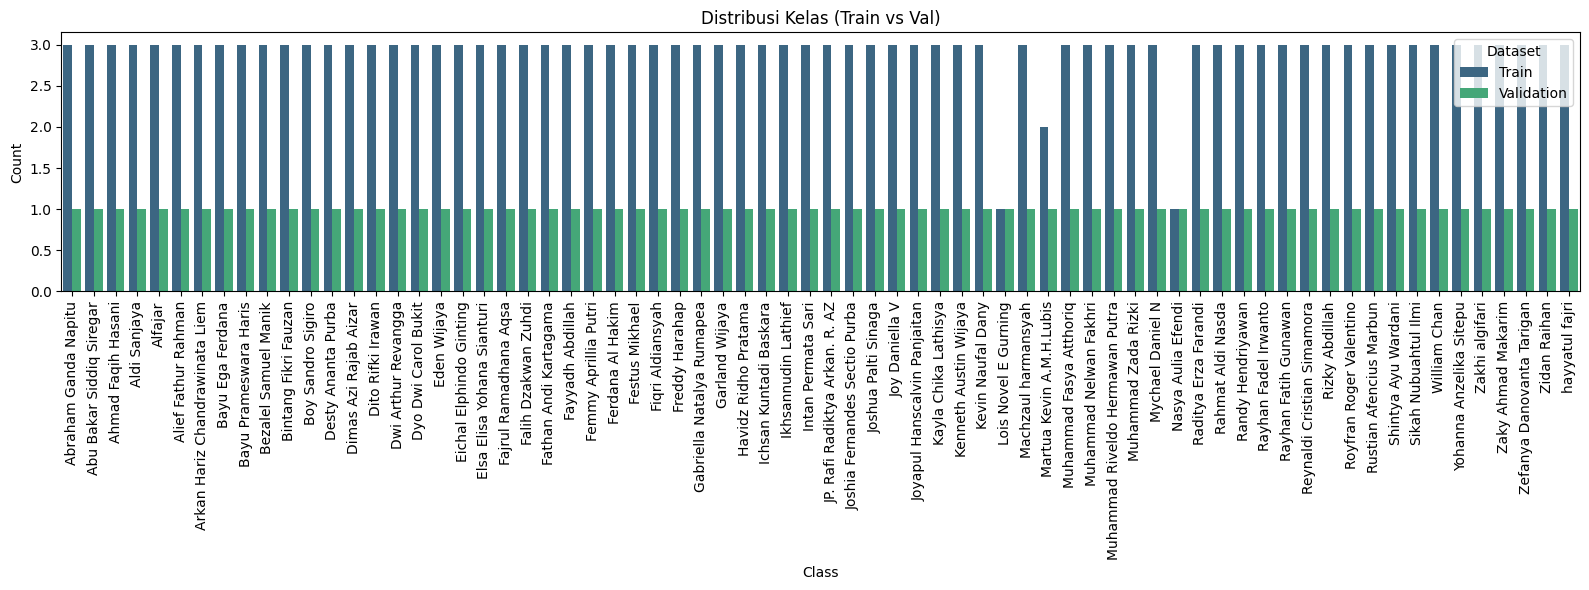

In [ ]:
import seaborn as sns
import pandas as pd

all_targets_np = np.array(ds_base.targets)

train_targets = all_targets_np[train_idx]
train_counts = np.bincount(train_targets, minlength=num_classes)

val_targets = all_targets_np[val_idx]
val_counts = np.bincount(val_targets, minlength=num_classes)

df_eda = pd.DataFrame({
    'Class': [class_names[i] for i in range(num_classes)] * 2,
    'Count': np.concatenate([train_counts, val_counts]),
    'Dataset': ['Train'] * num_classes + ['Validation'] * num_classes
})

plt.figure(figsize=(16, 6))
sns.barplot(x='Class', y='Count', hue='Dataset', data=df_eda, palette='viridis')
plt.title('Distribusi Kelas (Train vs Val)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 7. Training Loop Functions

Fungsi utama training yang mencakup:

- AMP (Automatic Mixed Precision): Menggunakan GradScaler dan autocast.
- Save Best Model: Menyimpan model hanya jika akurasi validasi meningkat.

In [ ]:
def run_training(model, dataloaders, config, class_names, model_name_tag="model"):
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params_to_update, lr=config["lr"], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"])
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scaler = GradScaler(enabled=config["use_amp"])

    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    save_filename = f"best_{model_name_tag}.pth"
    save_path = Path(config["artifacts_dir"]) / save_filename

    print(f"Start Training [{model_name_tag}]: {config['epochs']} epochs...")

    for epoch in range(1, config["epochs"] + 1):
        # --- TRAINING PHASE ---
        model.train()
        run_loss, run_correct, total = 0.0, 0, 0

        for x, y in dataloaders["train"]:
            x, y = x.to(CONFIG["device"]), y.to(CONFIG["device"])

            optimizer.zero_grad()

            with autocast(enabled=CONFIG["use_amp"]):
                outputs = model(x)
                loss = criterion(outputs, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            run_loss += loss.item() * x.size(0)
            run_correct += (outputs.argmax(1) == y).sum().item()
            total += x.size(0)

        train_loss = run_loss / total
        train_acc  = run_correct / total

        # --- VALIDATION PHASE ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in dataloaders["val"]:
                x, y = x.to(CONFIG["device"]), y.to(CONFIG["device"])
                outputs = model(x)
                loss = criterion(outputs, y)

                val_loss += loss.item() * x.size(0)
                val_correct += (outputs.argmax(1) == y).sum().item()
                val_total += x.size(0)

        val_loss = val_loss / val_total
        val_acc  = val_correct / val_total

        # Ambil LR saat ini
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()

        print(f"[{model_name_tag}] Ep {epoch}/{config['epochs']} | "
              f"TLoss: {train_loss:.4f} TAcc: {train_acc:.4f} | "
              f"VLoss: {val_loss:.4f} VAcc: {val_acc:.4f} | "
              f"LR: {current_lr:.2e}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'state_dict': model.state_dict(),
                'class_names': class_names,
                'config': config,
                'accuracy': best_acc,
                'model_type': model_name_tag
            }, save_path)
            print("Best model saved! val_acc: ", best_acc)

    print(f"Training Selesai [{model_name_tag}]. Best Val Acc: {best_acc:.4f}")
    return history


## 8. Model 1: InceptionResnetV1 + VGGFace2

Memuat model InceptionResnetV1 pretrained (VGGFace2), menyesuaikan layer dan klasifikasi akhir.

### 8.1 Model Initialization

In [ ]:
model_a = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=num_classes, dropout_prob=0.5)
model_a = model_a.to(CONFIG["device"])

  0%|          | 0.00/107M [00:00<?, ?B/s]

### 8.2 Model Training

In [ ]:
history_a = run_training(model_a, dataloaders, CONFIG, class_names, model_name_tag="inception_resnet")

Start Training [inception_resnet]: 40 epochs...
[inception_resnet] Ep 1/40 | TLoss: 4.0931 TAcc: 0.0829 | VLoss: 3.5178 VAcc: 0.3429 | LR: 1.00e-04
Best model saved! val_acc:  0.34285714285714286
[inception_resnet] Ep 2/40 | TLoss: 3.1185 TAcc: 0.5171 | VLoss: 2.7824 VAcc: 0.6286 | LR: 9.98e-05
Best model saved! val_acc:  0.6285714285714286
[inception_resnet] Ep 3/40 | TLoss: 2.5491 TAcc: 0.7659 | VLoss: 2.3447 VAcc: 0.7857 | LR: 9.94e-05
Best model saved! val_acc:  0.7857142857142857
[inception_resnet] Ep 4/40 | TLoss: 2.0951 TAcc: 0.8976 | VLoss: 2.0672 VAcc: 0.8429 | LR: 9.86e-05
Best model saved! val_acc:  0.8428571428571429
[inception_resnet] Ep 5/40 | TLoss: 1.8168 TAcc: 0.9171 | VLoss: 1.8126 VAcc: 0.8857 | LR: 9.76e-05
Best model saved! val_acc:  0.8857142857142857
[inception_resnet] Ep 6/40 | TLoss: 1.5393 TAcc: 0.9366 | VLoss: 1.5649 VAcc: 0.9571 | LR: 9.62e-05
Best model saved! val_acc:  0.9571428571428572
[inception_resnet] Ep 7/40 | TLoss: 1.4734 TAcc: 0.9463 | VLoss: 1.49

### 8.3 Model Evaluation

In [ ]:
# Load Best Model
model_a_path = Path(CONFIG["artifacts_dir"]) / "best_inception_resnet.pth"
checkpoint = torch.load(model_a_path, map_location=CONFIG["device"])
model_a.load_state_dict(checkpoint['state_dict'])
model_a.eval()

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:
# Generate Confusion Matrix
all_y, all_pred = [], []
with torch.no_grad():
    for x, y in dataloaders["val"]:
        x = x.to(CONFIG["device"])
        logits = model_a(x)
        preds = logits.argmax(1).cpu().numpy()
        all_y.extend(y.numpy())
        all_pred.extend(preds)

print(classification_report(all_y, all_pred, target_names=class_names, zero_division=0))

                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       1.00      1.00      1.00         1
       Abu Bakar Siddiq Siregar       1.00      1.00      1.00         1
             Ahmad Faqih Hasani       1.00      1.00      1.00         1
                   Aldi Sanjaya       1.00      1.00      1.00         1
                        Alfajar       1.00      1.00      1.00         1
            Alief Fathur Rahman       1.00      1.00      1.00         1
 Arkan Hariz Chandrawinata Liem       1.00      1.00      1.00         1
               Bayu Ega Ferdana       1.00      1.00      1.00         1
          Bayu Prameswara Haris       1.00      1.00      1.00         1
           Bezalel Samuel Manik       1.00      1.00      1.00         1
           Bintang Fikri Fauzan       1.00      1.00      1.00         1
              Boy Sandro Sigiro       1.00      1.00      1.00         1
             Desty Ananta Purba       1.00      1.

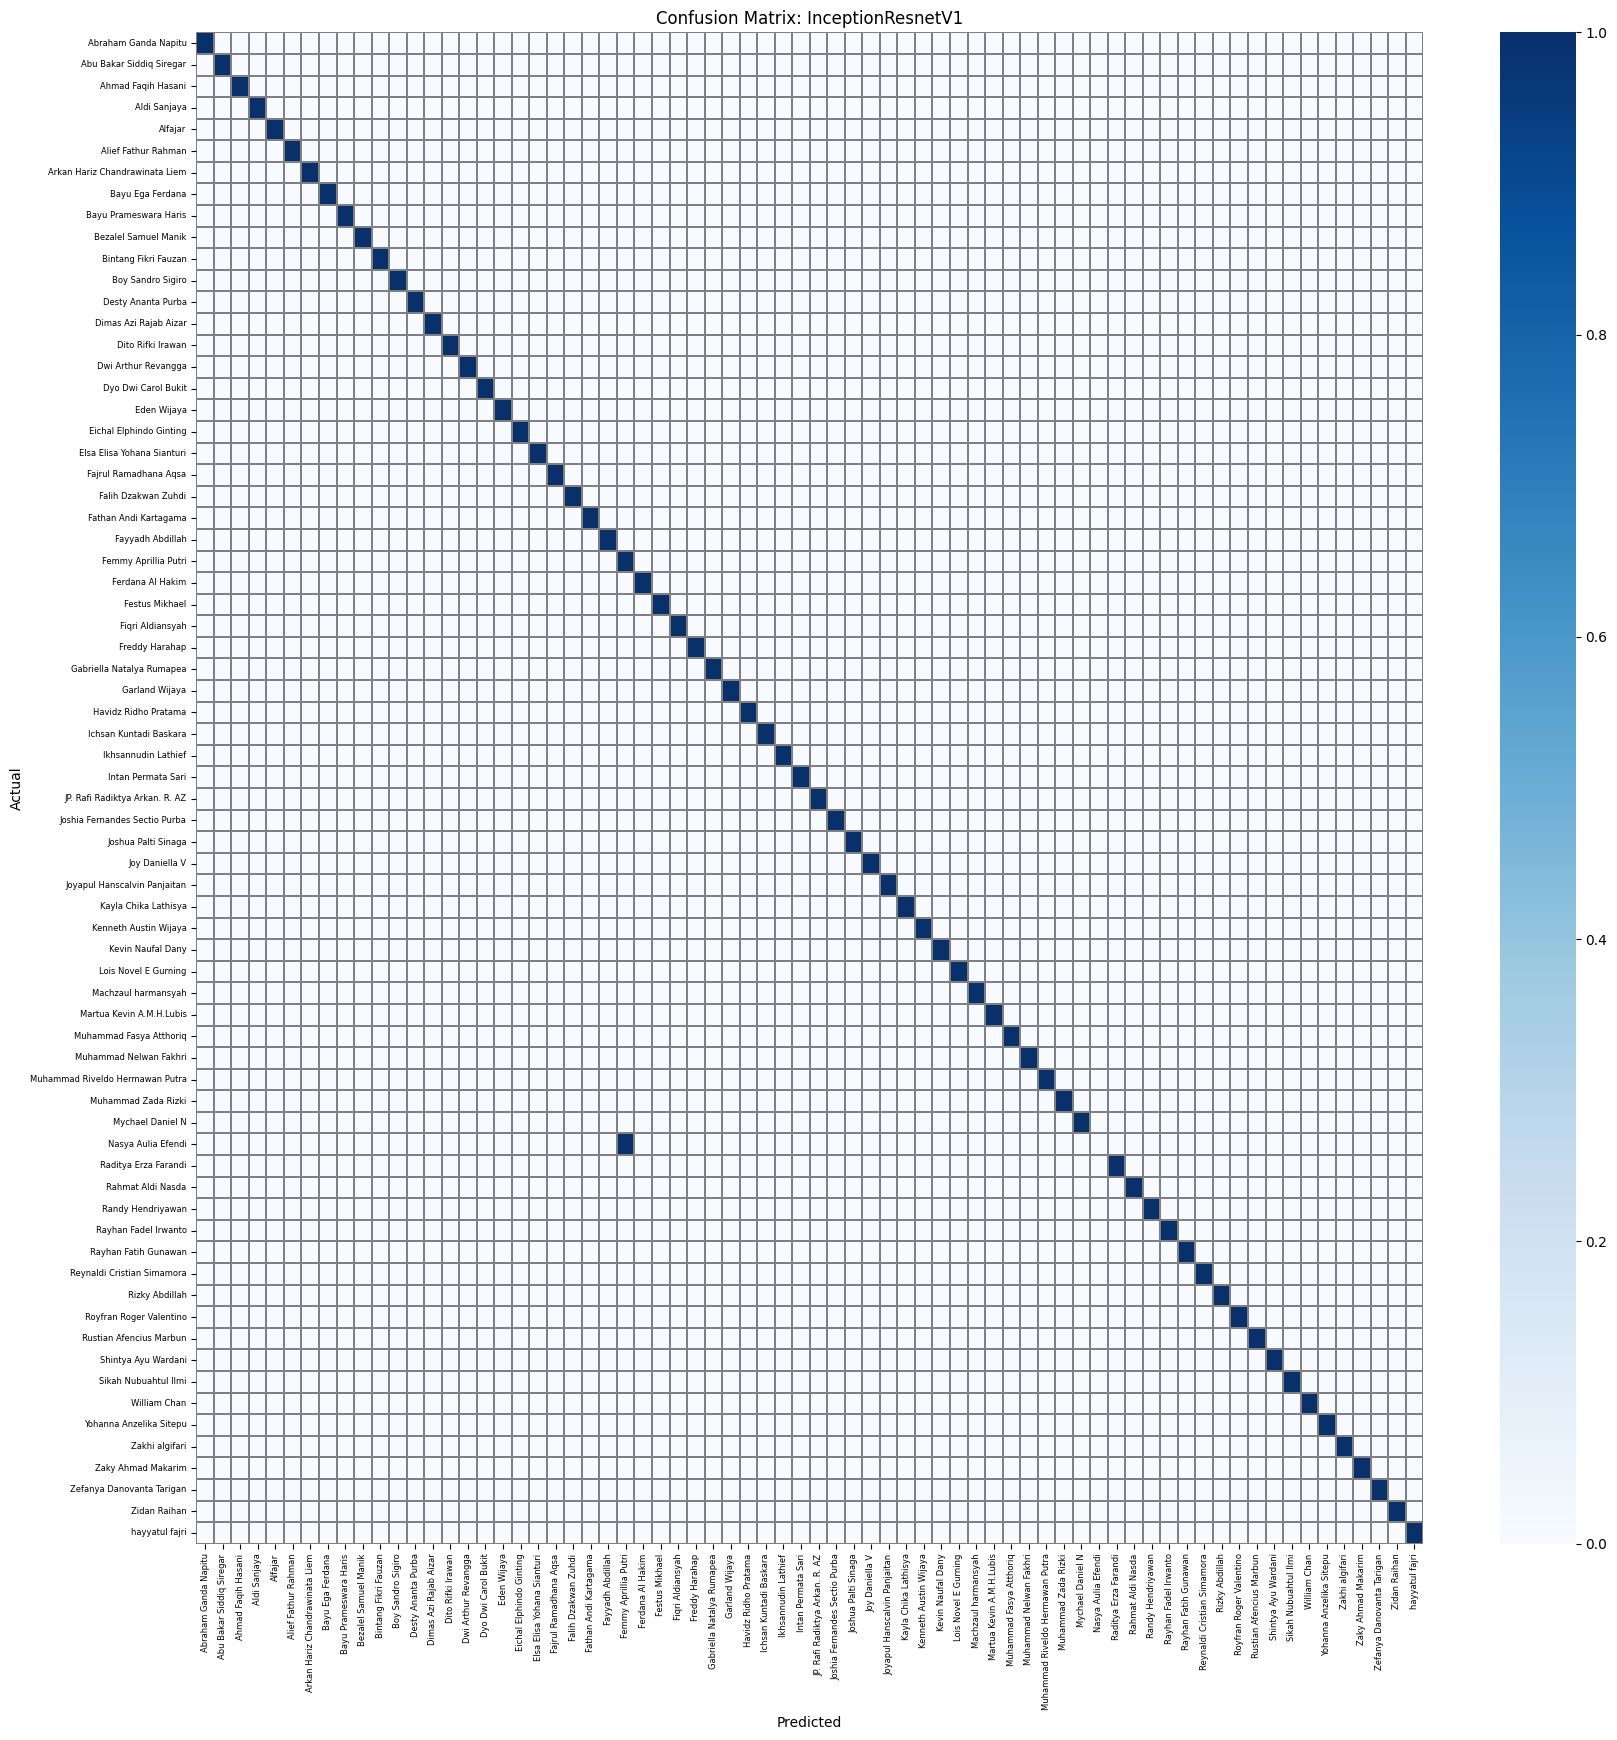

In [ ]:
cm = confusion_matrix(all_y, all_pred)
num_classes = len(class_names)
size = max(10, num_classes * 0.25)  # auto-scale
plt.figure(figsize=(size, size))
sns.heatmap(
    cm,
    cmap="Blues",
    annot=False,
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.2,
    linecolor="gray"
)

plt.title("Confusion Matrix: InceptionResnetV1")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.show()

## 9. Model 2: Resnet + ImageNet 1k

### 9.1 Initialize Model

In [ ]:
torch.cuda.empty_cache()

# 2. Inisialisasi Model B (Langsung & Custom Layers)
weights = models.ResNet50_Weights.DEFAULT
model_b = models.resnet50(weights=weights)

# Freeze layer
for param in model_b.parameters():
    param.requires_grad = False

# Ganti Head terakhir
num_ftrs = model_b.fc.in_features
model_b.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

model_b = model_b.to(CONFIG["device"])


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


### 9.2 Model Training

In [ ]:
# 3. Jalankan Training Model B
history_b = run_training(model_b, dataloaders, CONFIG, class_names, model_name_tag="resnet50")

Start Training [resnet50]: 40 epochs...
[resnet50] Ep 1/40 | TLoss: 4.2633 TAcc: 0.0098 | VLoss: 4.2215 VAcc: 0.0000 | LR: 1.00e-04
[resnet50] Ep 2/40 | TLoss: 4.2374 TAcc: 0.0244 | VLoss: 4.2005 VAcc: 0.0286 | LR: 9.98e-05
Best model saved! val_acc:  0.02857142857142857
[resnet50] Ep 3/40 | TLoss: 4.2041 TAcc: 0.0439 | VLoss: 4.1767 VAcc: 0.1000 | LR: 9.94e-05
Best model saved! val_acc:  0.1
[resnet50] Ep 4/40 | TLoss: 4.1616 TAcc: 0.0585 | VLoss: 4.1595 VAcc: 0.1286 | LR: 9.86e-05
Best model saved! val_acc:  0.12857142857142856
[resnet50] Ep 5/40 | TLoss: 4.1282 TAcc: 0.1268 | VLoss: 4.1356 VAcc: 0.1714 | LR: 9.76e-05
Best model saved! val_acc:  0.17142857142857143
[resnet50] Ep 6/40 | TLoss: 4.1173 TAcc: 0.1220 | VLoss: 4.1171 VAcc: 0.1857 | LR: 9.62e-05
Best model saved! val_acc:  0.18571428571428572
[resnet50] Ep 7/40 | TLoss: 4.0672 TAcc: 0.1805 | VLoss: 4.0975 VAcc: 0.2429 | LR: 9.46e-05
Best model saved! val_acc:  0.24285714285714285
[resnet50] Ep 8/40 | TLoss: 4.0598 TAcc: 0.2

### 9.3 Model Evaluation

In [ ]:
model_b_path = Path(CONFIG["artifacts_dir"]) / "best_resnet50.pth"
checkpoint = torch.load(model_b_path, map_location=CONFIG["device"])
model_b.load_state_dict(checkpoint['state_dict'])
model_b.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Generate Confusion Matrix
all_y, all_pred = [], []
with torch.no_grad():
    for x, y in dataloaders["val"]:
        x = x.to(CONFIG["device"])
        logits = model_b(x)
        preds = logits.argmax(1).cpu().numpy()
        all_y.extend(y.numpy())
        all_pred.extend(preds)

print(classification_report(all_y, all_pred, target_names=class_names, zero_division=0))

                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       1.00      1.00      1.00         1
       Abu Bakar Siddiq Siregar       1.00      1.00      1.00         1
             Ahmad Faqih Hasani       0.50      1.00      0.67         1
                   Aldi Sanjaya       1.00      1.00      1.00         1
                        Alfajar       0.00      0.00      0.00         1
            Alief Fathur Rahman       0.50      1.00      0.67         1
 Arkan Hariz Chandrawinata Liem       0.50      1.00      0.67         1
               Bayu Ega Ferdana       0.00      0.00      0.00         1
          Bayu Prameswara Haris       0.00      0.00      0.00         1
           Bezalel Samuel Manik       1.00      1.00      1.00         1
           Bintang Fikri Fauzan       0.00      0.00      0.00         1
              Boy Sandro Sigiro       1.00      1.00      1.00         1
             Desty Ananta Purba       0.00      0.

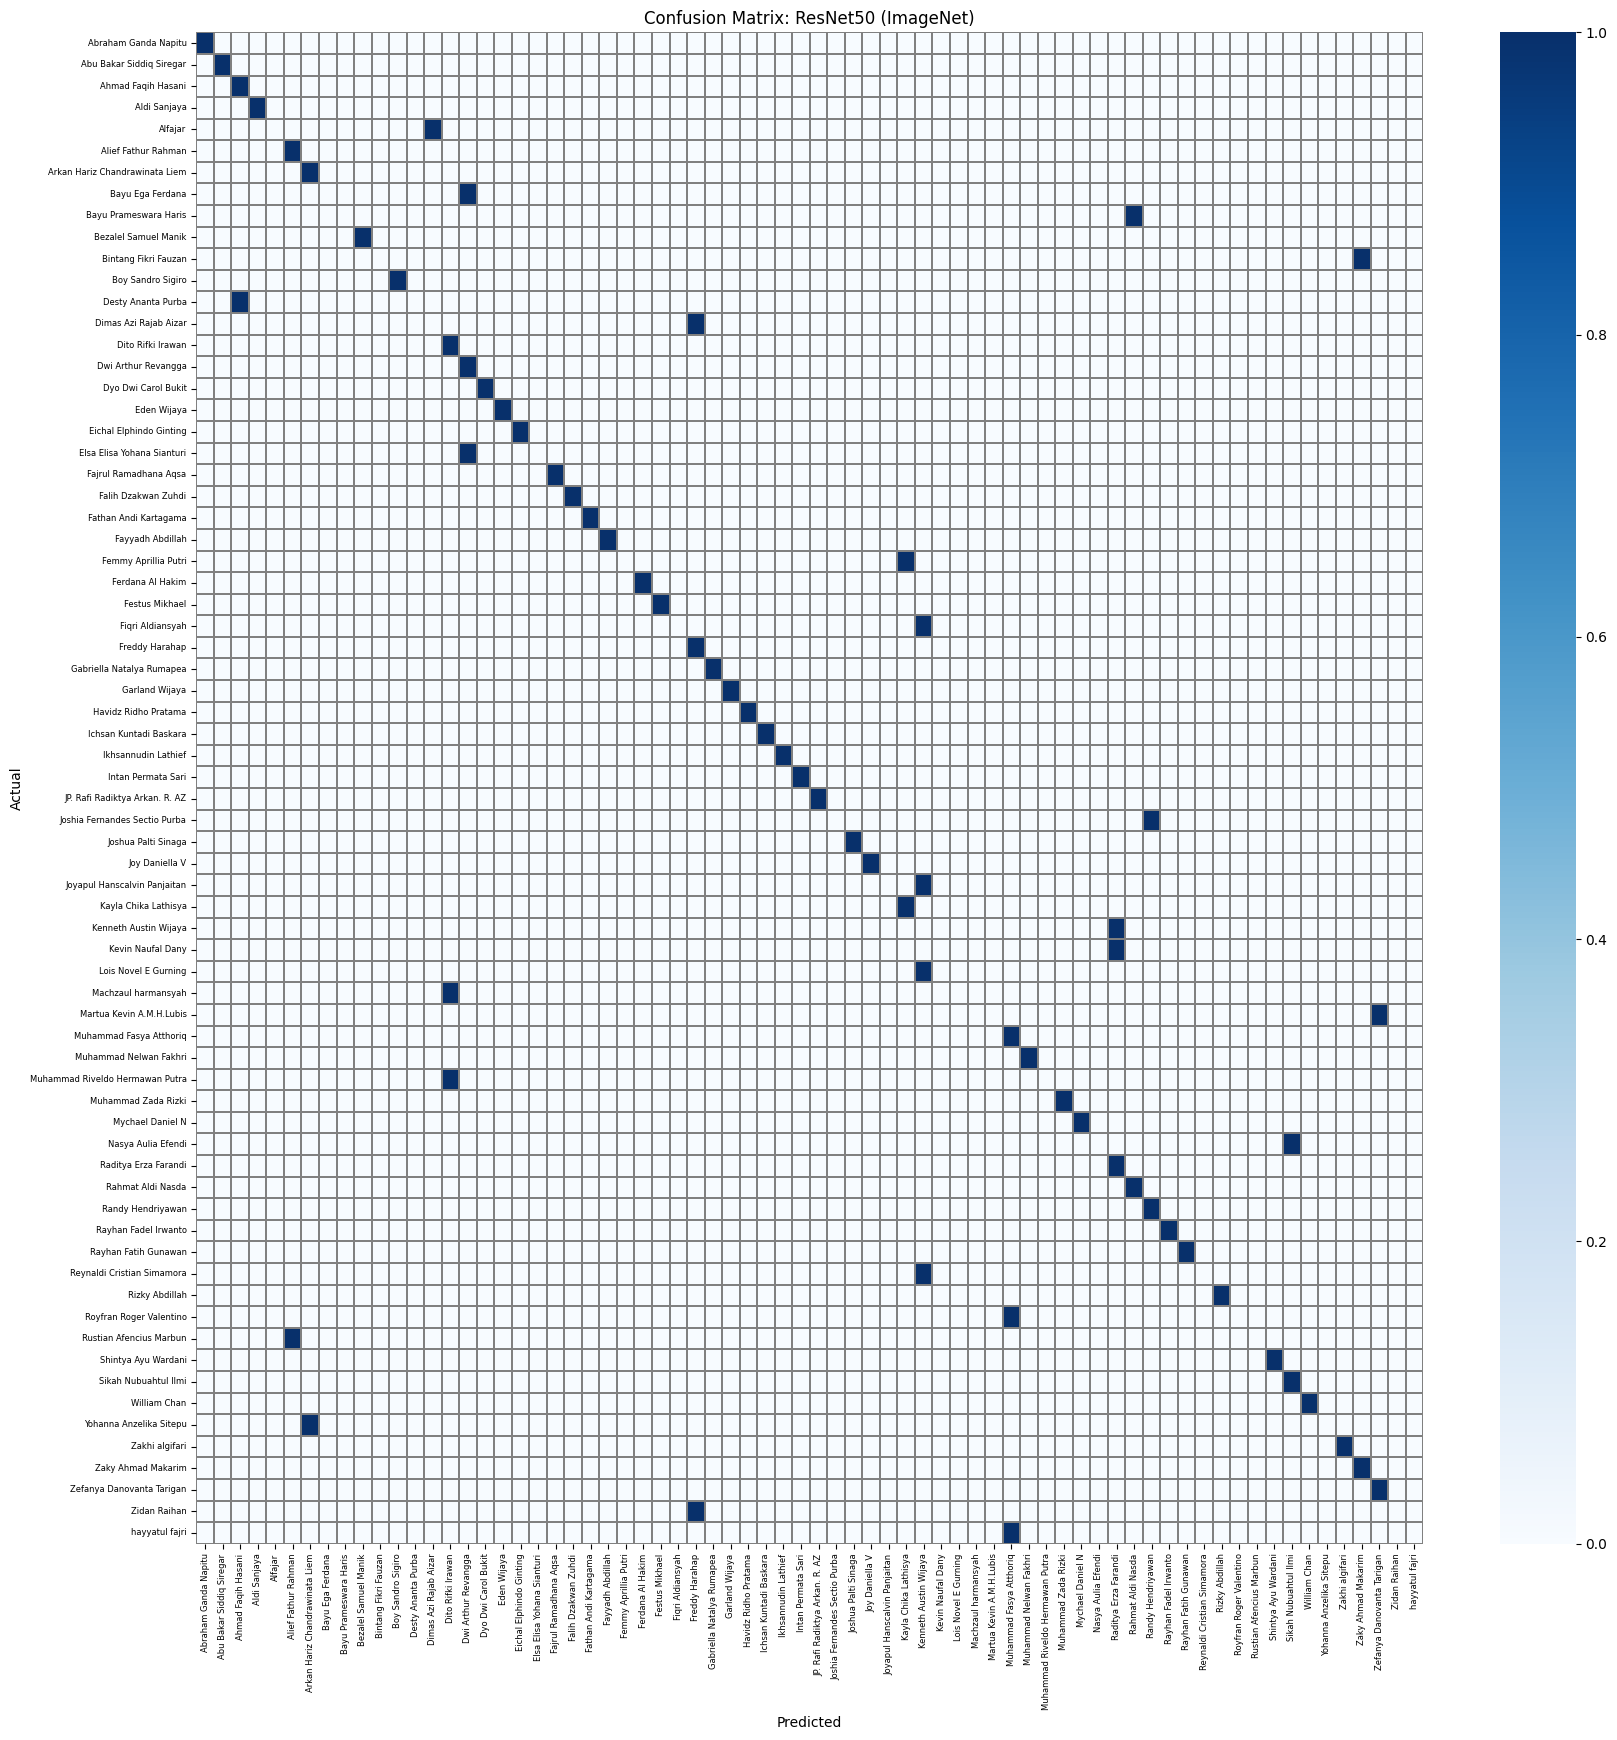

In [ ]:
cm = confusion_matrix(all_y, all_pred)
num_classes = len(class_names)
size = max(10, num_classes * 0.25)
plt.figure(figsize=(size, size))
sns.heatmap(
    cm,
    cmap="Blues",
    annot=False,
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.2,
    linecolor="gray"
)

plt.title("Confusion Matrix: ResNet50 (ImageNet)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.show()

## 10. Evaluasi

Melakukan evaluasi mendalam menggunakan Confusion Matrix pada dataset validasi menggunakan model terbaik yang telah disimpan.

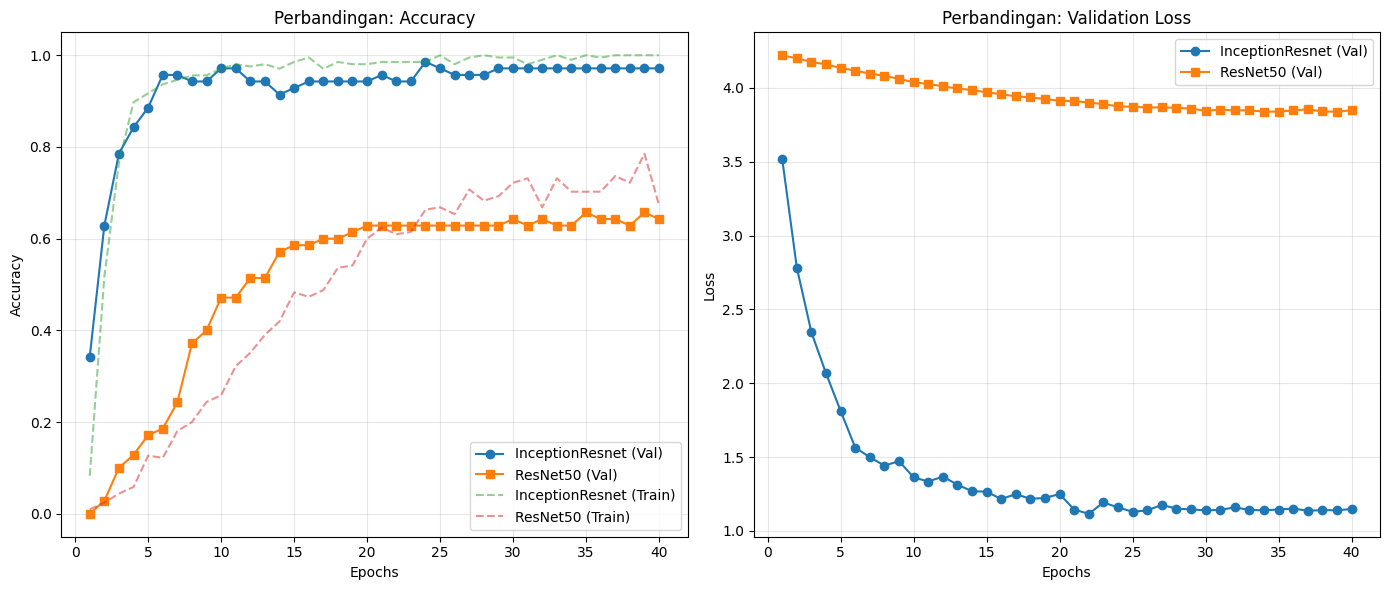

In [ ]:
# Note: Pastikan Anda sudah menjalankan Training Track A dan Track B sebelumnya
# sehingga variabel history_a dan history_b tersedia.

# Plot Comparison (History A vs History B)
epochs_range = range(1, CONFIG["epochs"] + 1)

plt.figure(figsize=(14, 6))

# Plot Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_a["val_acc"], label="InceptionResnet (Val)", marker='o')
plt.plot(epochs_range, history_b["val_acc"], label="ResNet50 (Val)", marker='s')
plt.plot(epochs_range, history_a["train_acc"], label="InceptionResnet (Train)", linestyle='--', alpha=0.5)
plt.plot(epochs_range, history_b["train_acc"], label="ResNet50 (Train)", linestyle='--', alpha=0.5)
plt.title("Perbandingan: Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_a["val_loss"], label="InceptionResnet (Val)", marker='o')
plt.plot(epochs_range, history_b["val_loss"], label="ResNet50 (Val)", marker='s')
plt.title("Perbandingan: Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 11. Inference / Demo

In [ ]:
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image

def preprocess_one_image(img_pil):
    img_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    faces = face_app.get(img_bgr)

    if len(faces) == 0:
        # Fallback resize jika wajah tidak terdeteksi
        face_aligned = cv2.resize(img_bgr, (CONFIG["img_size"], CONFIG["img_size"]))
    else:
        # Crop wajah terbesar
        target_face = sorted(faces, key=lambda x: x.det_score, reverse=True)[0]
        face_aligned = custom_norm_crop(img_bgr, target_face.kps, image_size=CONFIG["img_size"], crop_scale=CONFIG["crop_scale"])

    face_rgb = cv2.cvtColor(face_aligned, cv2.COLOR_BGR2RGB)
    face_pil = Image.fromarray(face_rgb)

    # Gunakan transformasi validasi (hanya normalisasi, tanpa augmentasi)
    tensor = val_tf(face_pil).unsqueeze(0)
    return tensor, face_pil

uploader = widgets.FileUpload(accept="image/*", multiple=False)
out = widgets.Output()

def on_upload(change):
    with out:
        clear_output()
        if not uploader.value: return

        file_info = list(uploader.value.values())[0]
        img = Image.open(io.BytesIO(file_info["content"])).convert("RGB")

        # Preprocess & Predict
        x_tensor, face_crop = preprocess_one_image(img)
        x_tensor = x_tensor.to(CONFIG["device"])

        model.eval()
        with torch.no_grad():
            logits = model(x_tensor)
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

        top_idx = np.argsort(probs)[::-1][:3]

        print("Prediksi Teratas:")
        for i in top_idx:
            print(f"- {class_names[i]}: {probs[i]*100:.2f}%")

        display(face_crop)

uploader.observe(on_upload, names='value')
display(widgets.VBox([widgets.Label("Upload gambar untuk tes:"), uploader, out]))


## 12. Deployment API Backend

In [ ]:
# !pip install flask flask-cors pyngrok

# from flask import Flask, request, jsonify
# from flask_cors import CORS
# from pyngrok import ngrok
# import threading

# # Masukkan Authtoken Ngrok Anda di sini
# NGROK_AUTH_TOKEN = "MASUKKAN_TOKEN_NGROK_DISINI"
# ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# app = Flask(__name__)
# CORS(app)

In [ ]:
# @app.route('/predict', methods=['POST'])
# def predict():
#     if 'file' not in request.files:
#         return jsonify({'error': 'No file'}), 400

#     file = request.files['file']
#     img = Image.open(file).convert('RGB')

#     # Reuse logic inference
#     x_tensor, _ = preprocess_one_image(img)
#     x_tensor = x_tensor.to(CONFIG["device"])

#     with torch.no_grad():
#         logits = model(x_tensor)
#         probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

#     top_idx = np.argsort(probs)[::-1][:5]
#     results = []
#     for i in top_idx:
#         results.append({
#             "class": class_names[i],
#             "confidence": float(probs[i])
#         })

#     return jsonify({"predictions": results})

In [ ]:
# # Jalankan di background thread
# def run_flask():
#     app.run(port=5000, use_reloader=False)

# threading.Thread(target=run_flask).start()

In [ ]:
# # Buka Tunnel
# try:
#     public_url = ngrok.connect(5000).public_url
#     print(f"API Public URL: {public_url}/predict")
# except Exception as e:
#     print("Ngrok Error:", e)